In [7]:
import h5py
import numpy as np
import random
from sklearn.metrics import silhouette_score, v_measure_score
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sknetwork.clustering import Louvain
import matplotlib.pyplot as plt


# Load Data Content
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')

data_content = {
    'pge': pge_content,
    'resnet50': resnet50_content,
    'inceptionv3': inceptionv3_content,
    'vgg16': vgg16_content
}

In [8]:
# Constants
feature_types = ['pca', 'umap']
representations = ['pge', 'resnet50', 'inceptionv3', 'vgg16']
modularity_options = ['Dugue', 'Newman', 'Potts']
random_state = 0
results_headers = dict({'Metrics': ['count', 'silhouette', 'V-measure']})


# Prepare Datasets
datasets = {representation: {feature: data_content[representation]['pca_feature'][...] for feature in feature_types} for representation in representations}
best_cluster_sizes = {}
best_scores = {}
scores_silhouette = []
scores_v_measure = []
cluster = []
print(f"Available representations: {representations}")


Available representations: ['pge', 'resnet50', 'inceptionv3', 'vgg16']


Available representations: ['pge', 'resnet50', 'inceptionv3', 'vgg16']
The choosen representation is:  pge


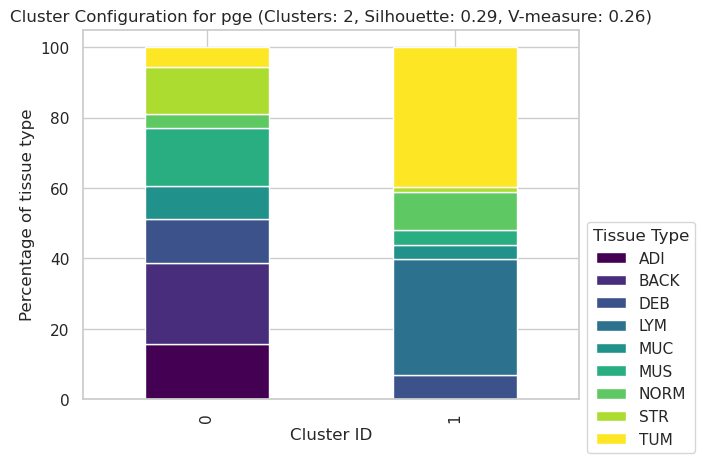

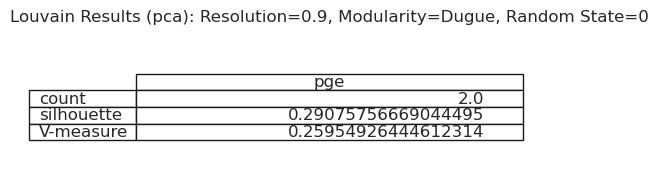

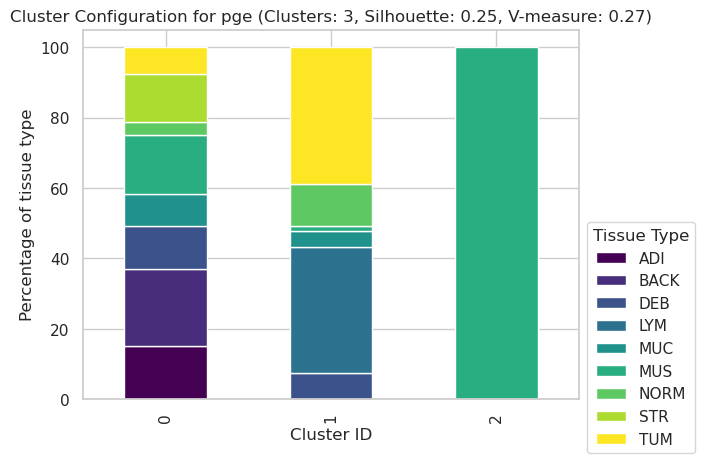

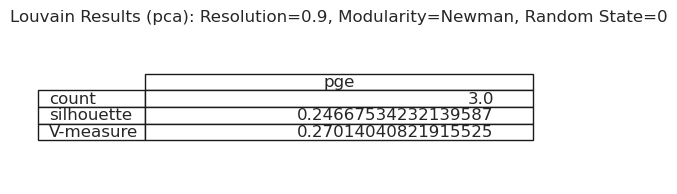

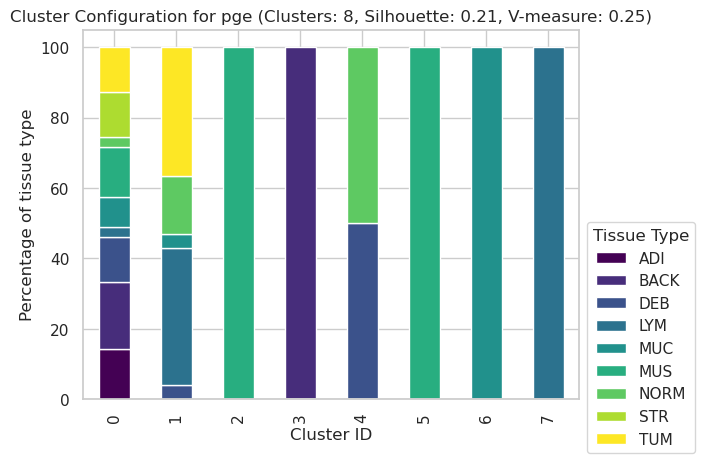

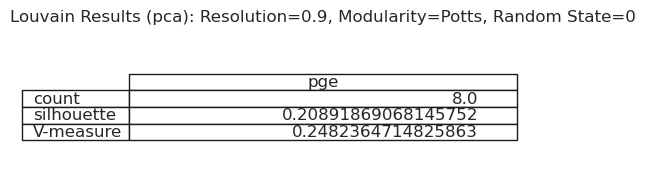

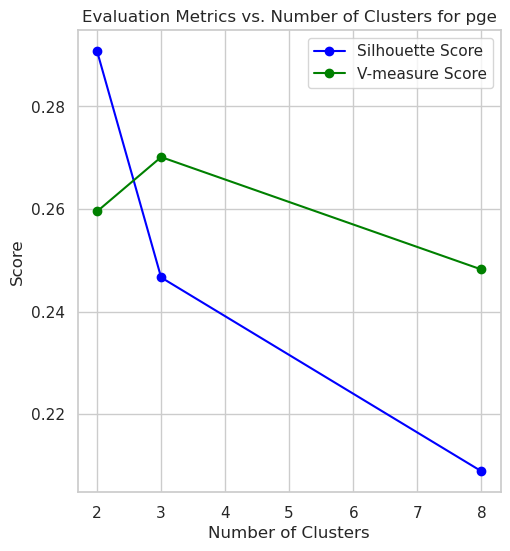

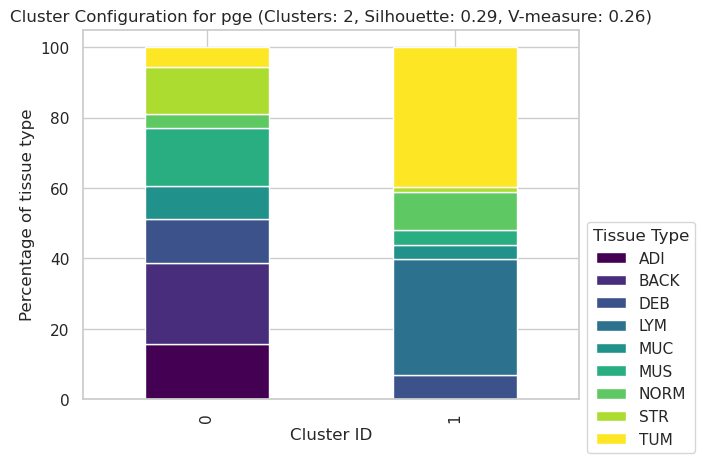

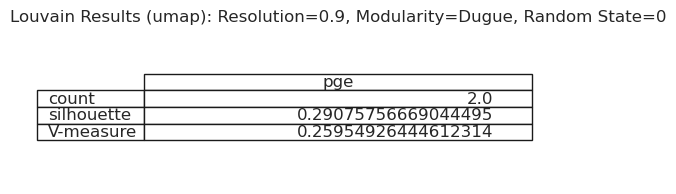

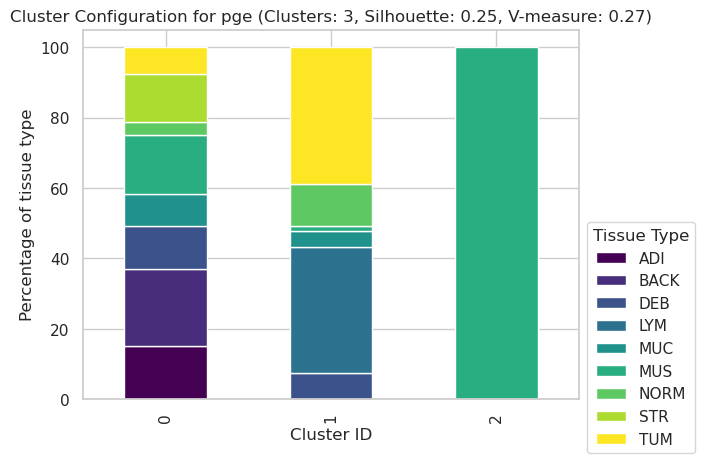

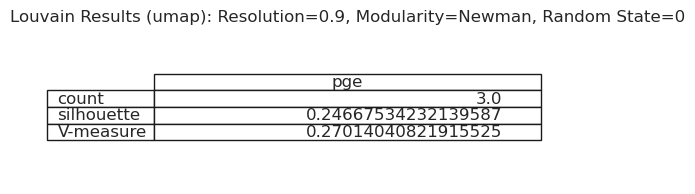

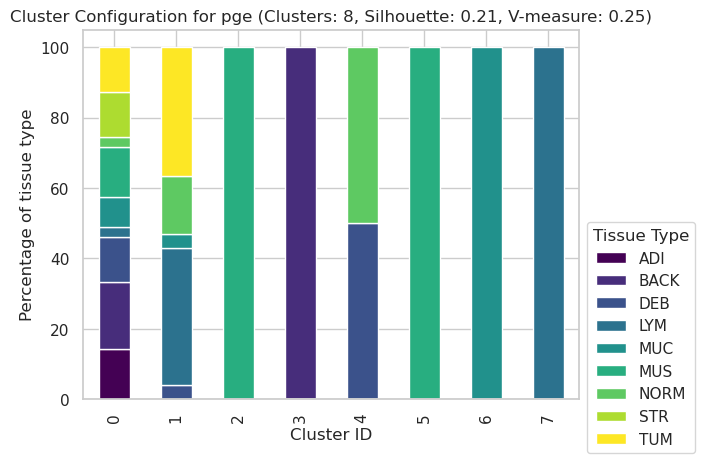

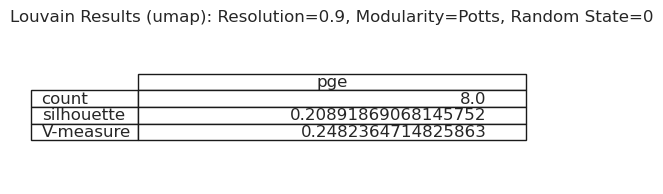

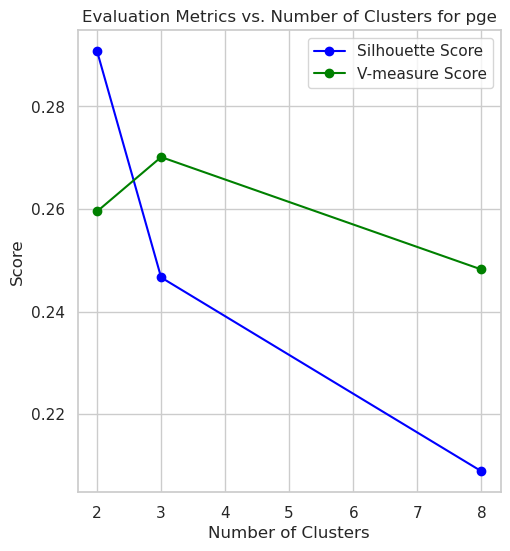

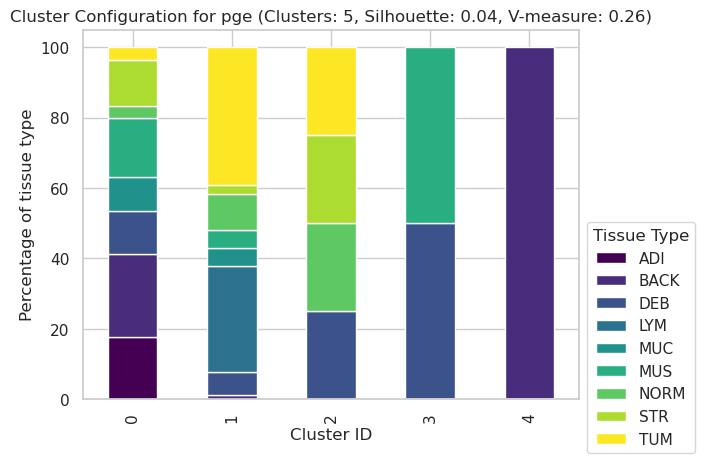

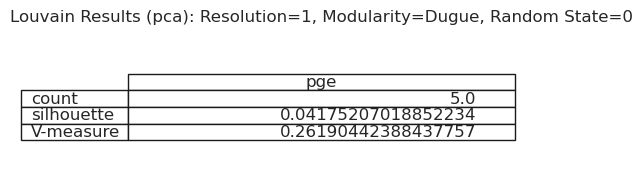

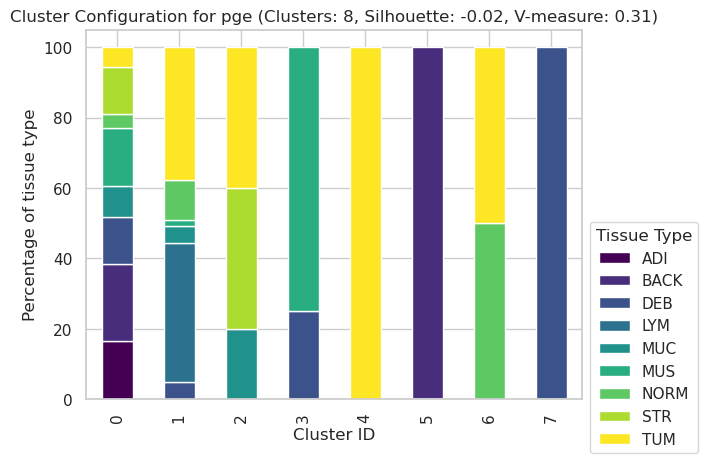

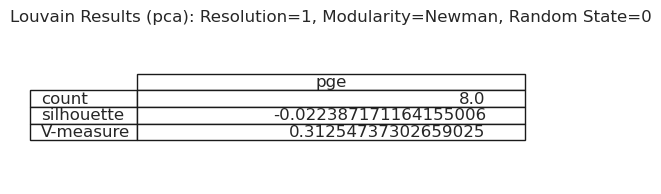

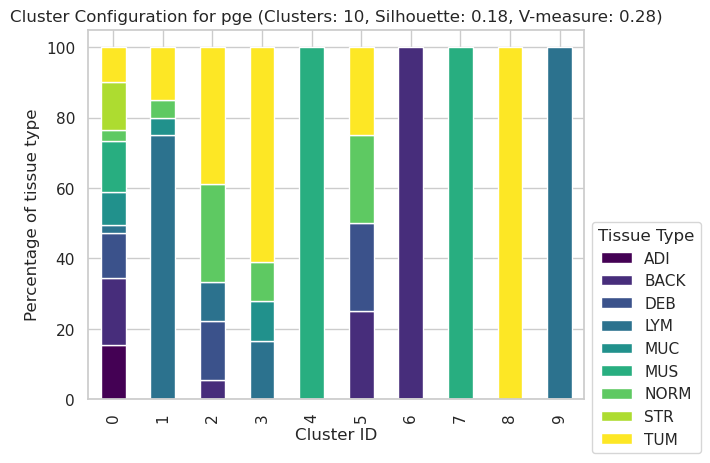

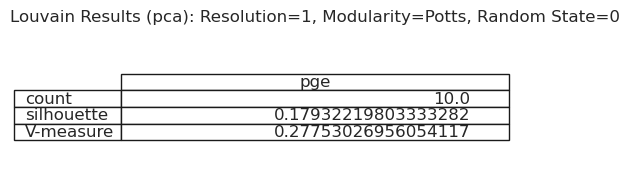

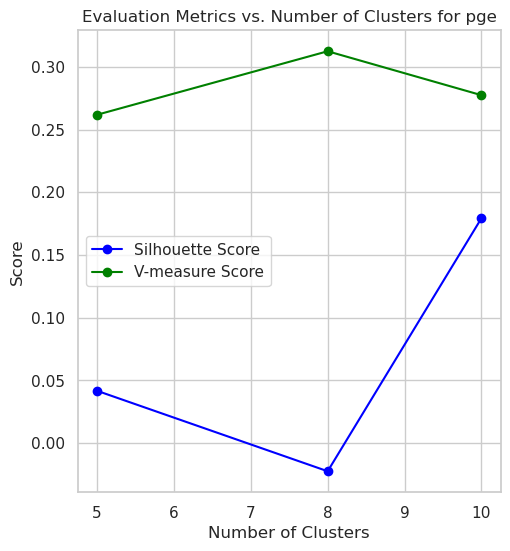

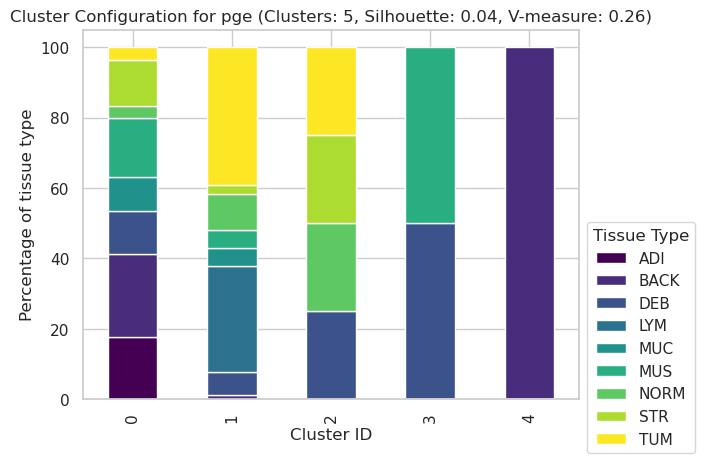

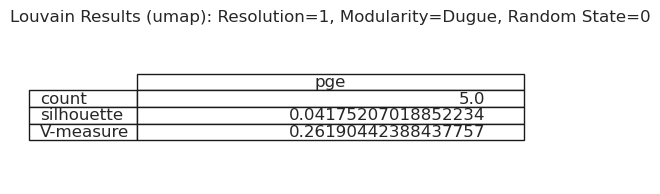

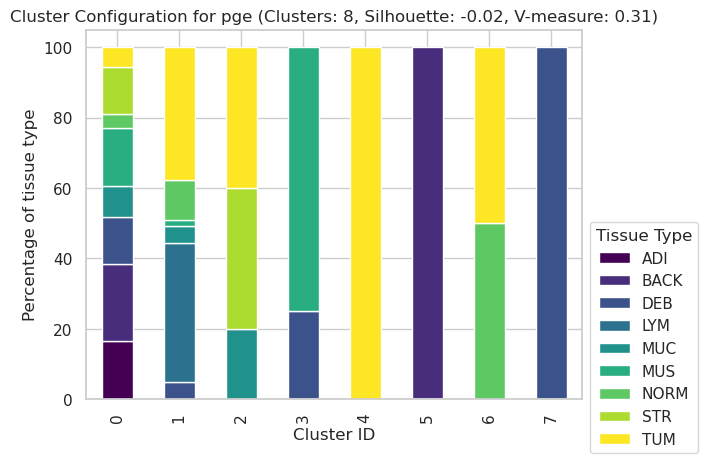

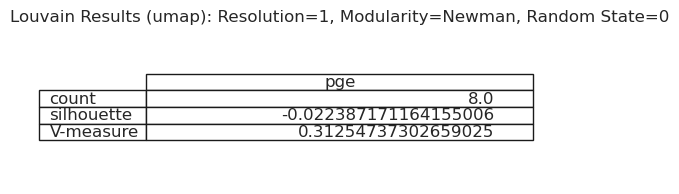

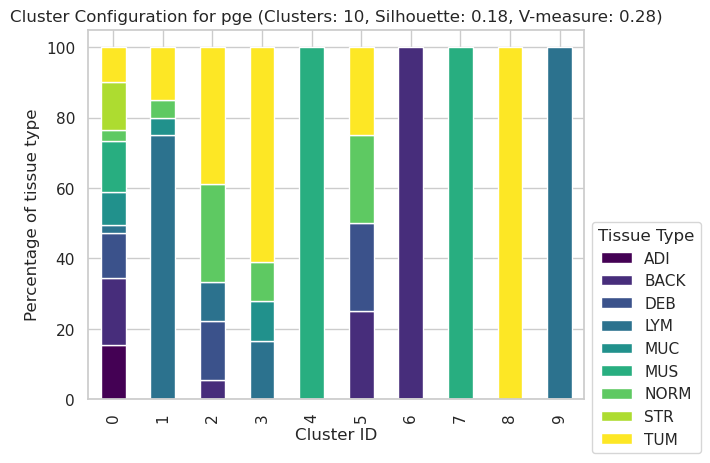

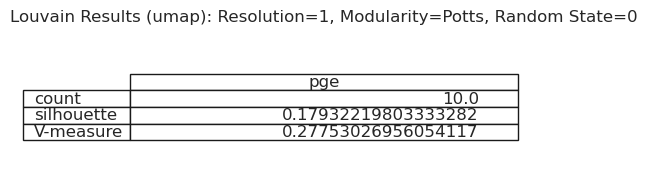

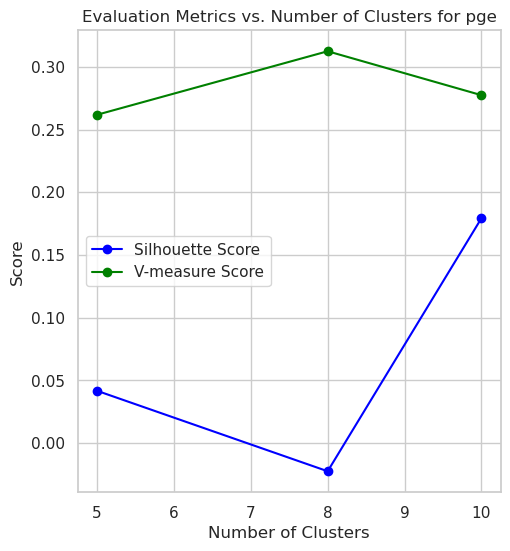

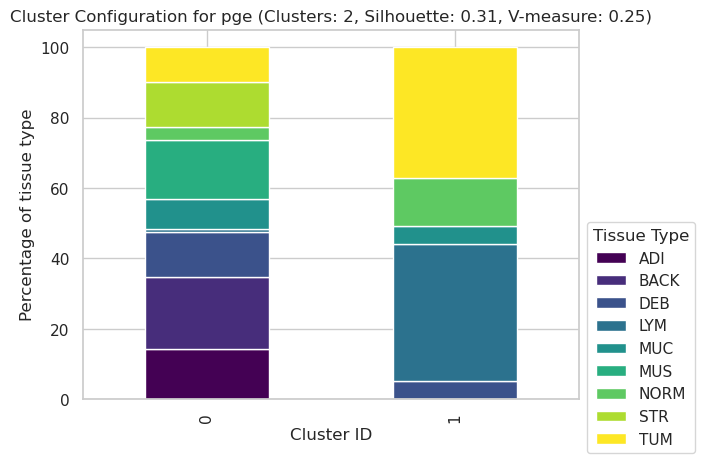

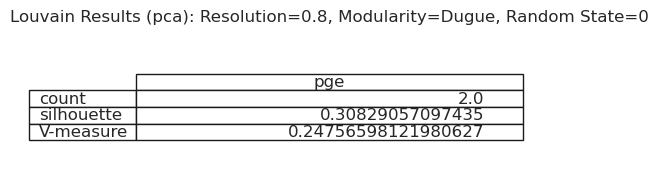

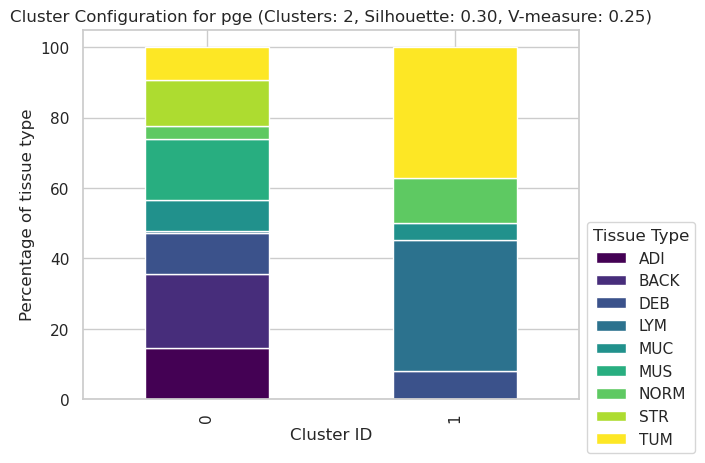

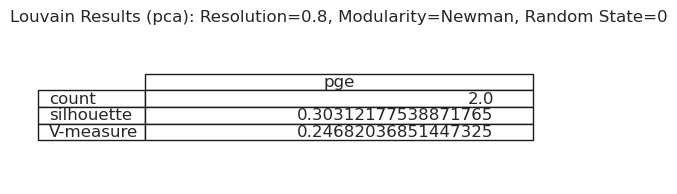

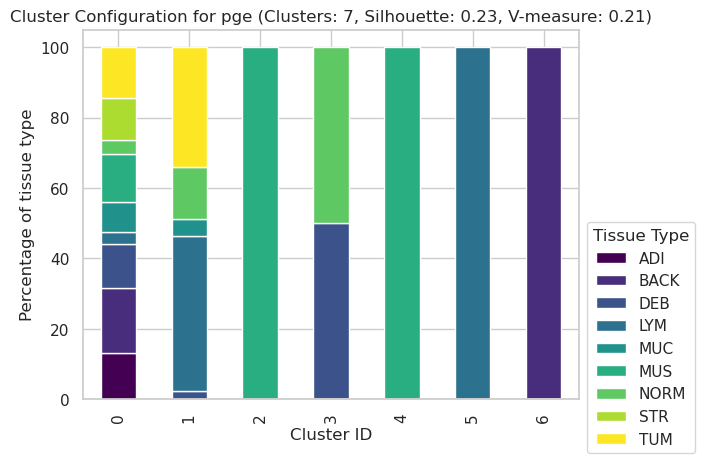

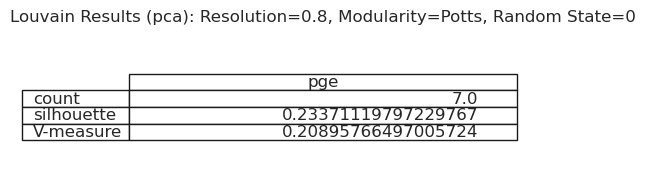

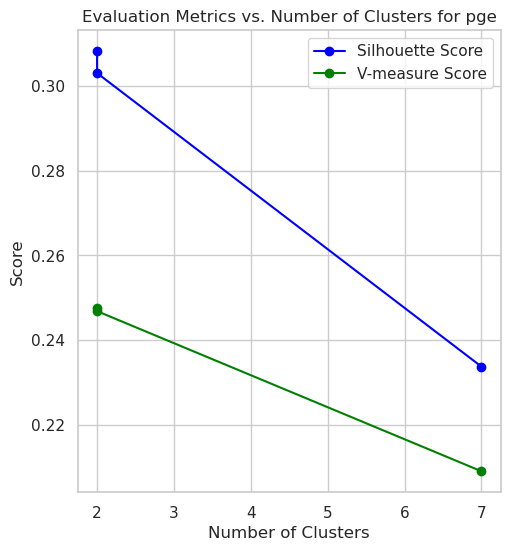

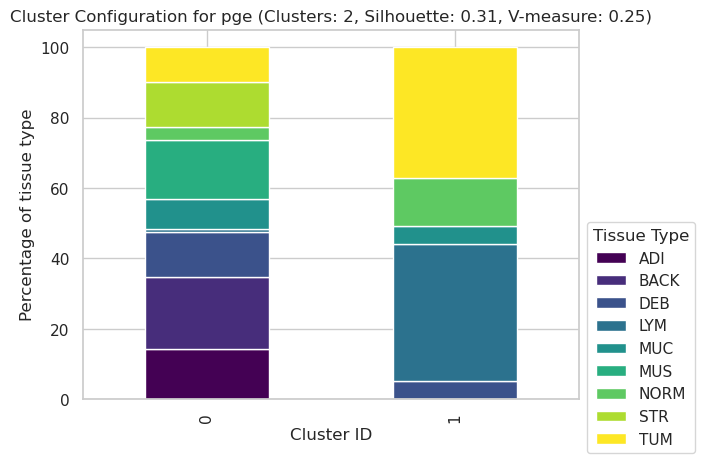

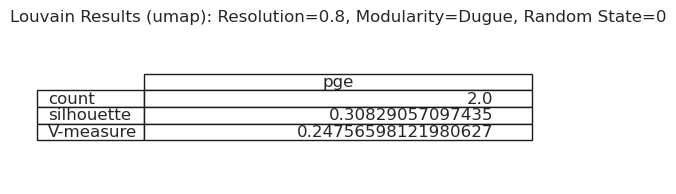

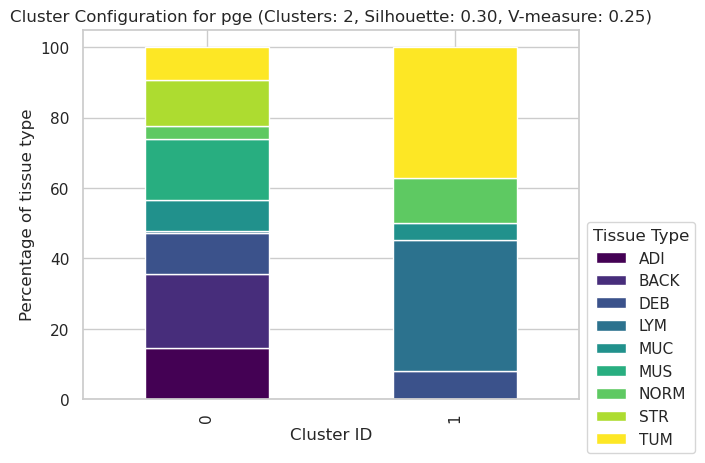

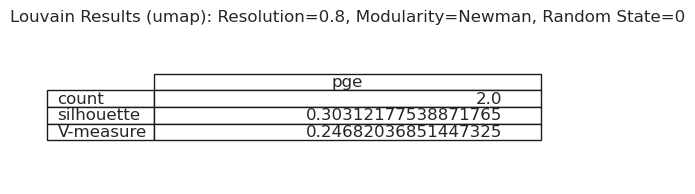

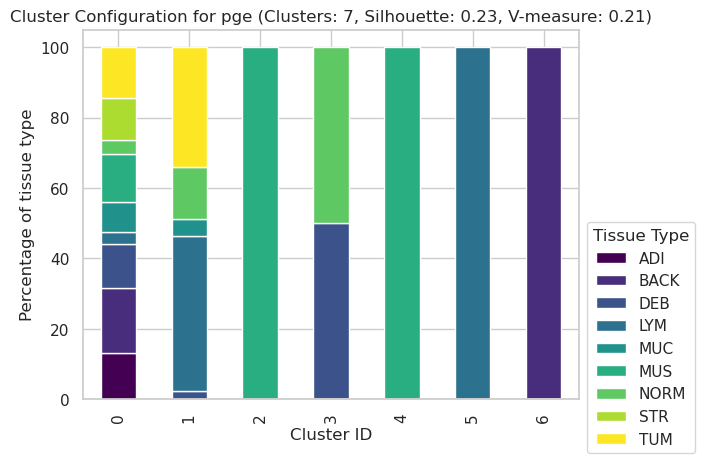

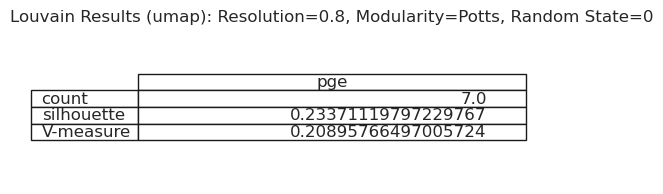

Best cluster size for pge: 10
Best silhouette score and v-measure score for pge: (0.1793222, 0.27753026956054117)


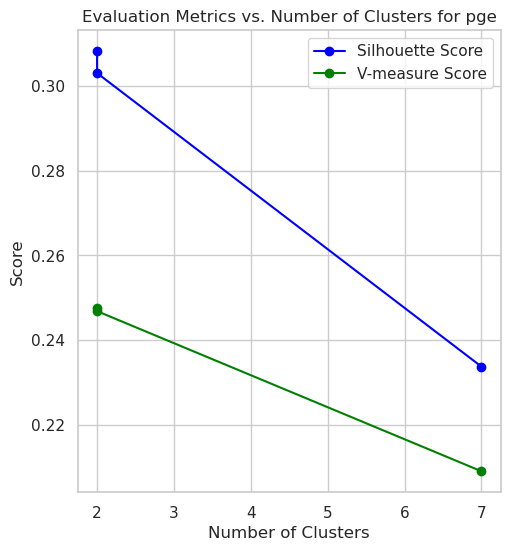

In [9]:
# Pick the representation
print(f"Available representations: {representations}")
representation = input("Enter the representation: ")
if representation not in representations:
    raise ValueError("Invalid representation")
else:
    print("The choosen representation is: ", representation)


# Main Script for Louvain Clustering
for resolution in [0.9, 1, 0.8]:
    for feature_type in feature_types:
        scores_silhouette.clear()
        scores_v_measure.clear()
        cluster.clear()
        for modularity in modularity_options:
            try:
                # Get Data
                dataset = datasets[representation][feature_type]

                # Get Testing Data
                filename = np.squeeze(data_content[representation]['file_name'])
                filename = np.array([str(x) for x in filename])
                labels = np.array([x.split('/')[2] for x in filename])
                random.seed(0)
                selected_index = random.sample(list(np.arange(len(dataset))), 200)
                test_data = dataset[selected_index]
                test_label = labels[selected_index]

                # Apply Louvain
                louvain_model = Louvain(resolution=resolution, modularity=modularity, random_state=random_state)
                adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(test_data)))
                louvain_assignment = louvain_model.fit_transform(adjacency_matrix)
                labels = louvain_model.fit_predict(adjacency_matrix)

                # Evaluation Metrics
                counts = np.unique(labels, return_counts=True)
                cluster_size = counts[0].size
                silhouette = silhouette_score(test_data, labels)
                v_measure = v_measure_score(test_label, labels)
                
                # Update best cluster size and scores
                if representation not in best_cluster_sizes:
                    best_cluster_sizes[representation] = cluster_size
                    best_scores[representation] = (silhouette, v_measure)
                else:
                    if cluster_size > best_cluster_sizes[representation]:
                        best_cluster_sizes[representation] = cluster_size
                        best_scores[representation] = (silhouette, v_measure)
                
                cluster.append(cluster_size)
                scores_silhouette.append(silhouette)
                scores_v_measure.append(v_measure)

                # Evaluation Metrics Results
                louvain_results = [int(counts[0].size),
                                silhouette_score(test_data, labels),
                                v_measure_score(test_label, labels)]
                
                label_proportion = pd.DataFrame({'clusterID': labels, 'type': test_label})
                label_proportion = label_proportion.groupby(['clusterID']).apply(lambda x: x['type'].value_counts(normalize=True)).unstack().fillna(0) * 100
                label_proportion.plot(kind='bar', stacked=True, colormap='viridis')
                sns.set(style="whitegrid")
                plt.title(f'Cluster Configuration for {representation} (Clusters: {cluster_size}, Silhouette: {silhouette:.2f}, V-measure: {v_measure:.2f})')
                plt.xlabel('Cluster ID')
                plt.ylabel('Percentage of tissue type')
                plt.legend(title='Tissue Type', loc='upper right', bbox_to_anchor=(1.25, 0.5))
                plt.grid(True)
                plt.show()
                
                louvain_results_dictionary = results_headers.copy()
                louvain_results_dictionary.update({representation: louvain_results})
                frame = pd.DataFrame(louvain_results_dictionary).set_index('Metrics')
                fig = plt.figure(figsize=(5, 2))
                ax = fig.add_subplot(111)
                ax.table(cellText=frame.values, rowLabels=frame.index, colLabels=frame.columns, loc="center")
                ax.set_title(f"Louvain Results ({feature_type}): Resolution={resolution}, Modularity={modularity}, Random State={random_state}")
                ax.axis("off")
                plt.show()

            except Exception as e:
                print(f"Error in: ({feature_type}): Resolution={resolution}, Modularity={modularity}, Random State={random_state}")
                print(e)
        # Plotting results of the metrics
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(cluster, scores_silhouette, marker='o', label='Silhouette Score', color='blue')
        plt.plot(cluster, scores_v_measure, marker='o', label='V-measure Score', color='green')
        plt.title('Evaluation Metrics vs. Number of Clusters for'+f' {representation}')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

# Display Results of Best Cluster Size and Scores at the end of the script
print(f"Best cluster size for {representation}: {best_cluster_sizes[representation]}")
print(f"Best silhouette score and v-measure score for {representation}: {best_scores[representation]}")

In [10]:
cluster

[2, 2, 7]

pca at 0.9          2, 3, 8
umap at 0.9         2, 3 ,8
pca at 1            5 , 8, 10
umap at 1           5, 8, 10
pca at 0.8          2, 2, 7
umap at 0.8         2, 2, 7


In [11]:
scores_silhouette

[0.30829057, 0.30312178, 0.2337112]